In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from scipy.signal import convolve2d

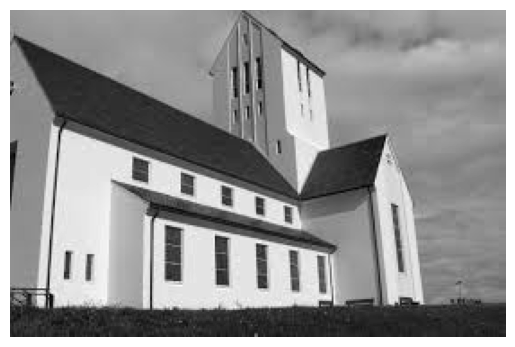

In [36]:
# Load image
image = plt.imread('image1.png')

# Convert to grayscale
if len(image.shape) == 3:
    image_gray = np.mean(image, axis=2)
else:
    image_gray = image

plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

In [37]:
# Define Sobel kernels
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Define Gaussian kernel
def gaussian_filter(sigma, size):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

# Convolution process with Gaussian filter
def convolve_gaussian(image, sigma):
    gaussian = gaussian_filter(sigma, 5)
    smoothed_image = convolve(image, gaussian)
    return smoothed_image

# Convolution process with Sobel filters
def convolve_sobel(image):
    gradient_x = convolve2d(image, sobel_x, mode='same')
    gradient_y = convolve2d(image, sobel_y, mode='same')
    edge_map = np.sqrt(gradient_x**2 + gradient_y**2)
    return gradient_x, gradient_y, edge_map

# Define Gaussian derivative kernels
def gaussian_derivative_x(sigma, size):
    kernel = np.fromfunction(lambda x, y: -((x - size//2)/(sigma**2)) * (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel

def gaussian_derivative_y(sigma, size):
    kernel = np.fromfunction(lambda x, y: -((y - size//2)/(sigma**2)) * (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel

# Convolution process with Gaussian derivative filters
def convolve_gaussian_derivatives(image, sigma):
    # Compute Gaussian derivative kernels
    kernel_size = 5
    gaussian_dx = gaussian_derivative_x(sigma, kernel_size)
    gaussian_dy = gaussian_derivative_y(sigma, kernel_size)
    
    # Convolve with image
    gradient_x = convolve(image, gaussian_dx)
    gradient_y = convolve(image, gaussian_dy)
    edge_map = np.sqrt(gradient_x**2 + gradient_y**2)
    
    return gradient_x, gradient_y, edge_map

def harris_corner_detection(img, window_size=3, k=0.04, threshold=0.01):
    # Calculate gradients
    dx = np.array([[1, 0, -1]])
    dy = dx.T
    Ix = convolve(img, dx)
    Iy = convolve(img, dy)

    # Structure tensor components
    Ix2 = Ix**2
    Iy2 = Iy**2
    Ixy = Ix * Iy

    # Gaussian filter for smoothing
    gaussian = gaussian_filter(1, window_size)
    Ix2_smoothed = convolve(Ix2, gaussian)
    Iy2_smoothed = convolve(Iy2, gaussian)
    Ixy_smoothed = convolve(Ixy, gaussian)

    # Harris corner response
    det_M = Ix2_smoothed * Iy2_smoothed - Ixy_smoothed**2
    trace_M = Ix2_smoothed + Iy2_smoothed
    corner_response = det_M - k * trace_M**2

    # Thresholding
    corners = np.zeros_like(img)
    corners[corner_response > threshold * np.max(corner_response)] = 255

    return corners

def non_max_suppression(corner_response, window_size=2):
    # Pad the corner response map
    padded_corner_response = np.pad(corner_response, ((window_size//2, window_size//2), (window_size//2, window_size//2)), mode='constant')

    # Initialize output map
    non_max = np.zeros_like(corner_response)

    # Iterate through each pixel in the corner response map
    for i in range(corner_response.shape[0]):
        for j in range(corner_response.shape[1]):
            # Extract the window around the current pixel
            window = padded_corner_response[i:i+window_size, j:j+window_size]

            # Check if the current pixel is the maximum within its window
            if corner_response[i, j] == np.max(window):
                non_max[i, j] = 255

    return non_max

def non_maximum_suppression(harris_response, threshold):
    # Create an array to store the corners
    corners = np.zeros_like(harris_response, dtype=np.int32)
    max_response = harris_response.max()
    offset = 1

    # Loop through the image, avoiding the borders
    for y in range(offset, harris_response.shape[0] - offset):
        for x in range(offset, harris_response.shape[1] - offset):
            window = harris_response[y-offset:y+offset+1, x-offset:x+offset+1]
            local_max = window.max()
            # Check if the current pixel is the local max and greater than the threshold
            if harris_response[y, x] == local_max and local_max >= threshold * max_response:
                corners[y, x] = 1
    return corners

def harris_corner_detection(Ix, Iy, k=0.01):
    height, width = Ix.shape
    harris_response = np.zeros((height, width))
    
    # Compute products of derivatives
    Ixx = Ix**2
    Ixy = Iy*Ix
    Iyy = Iy**2

    # Pad the matrices to avoid border issues
    pad = 1
    Ixx_padded = np.pad(Ixx, ((pad, pad), (pad, pad)), mode='constant')
    Ixy_padded = np.pad(Ixy, ((pad, pad), (pad, pad)), mode='constant')
    Iyy_padded = np.pad(Iyy, ((pad, pad), (pad, pad)), mode='constant')

    for y in range(pad, height + pad):
        for x in range(pad, width + pad):
            # Sum of squares of derivatives in the 3x3 window
            Sxx = np.sum(Ixx_padded[y - pad:y + pad + 1, x - pad:x + pad + 1])
            Syy = np.sum(Iyy_padded[y - pad:y + pad + 1, x - pad:x + pad + 1])
            Sxy = np.sum(Ixy_padded[y - pad:y + pad + 1, x - pad:x + pad + 1])

            # Compute the Harris response score
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = det - k * (trace**2)

            # Store the response in the original coordinates
            harris_response[y - pad, x - pad] = R

    return harris_response

# Plotting function
def plot_images(images, titles, cmap):
    num_images = len(images)
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Question 1 #

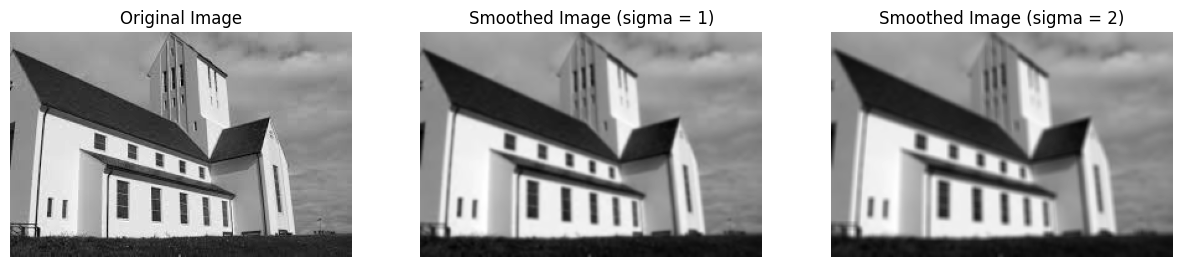

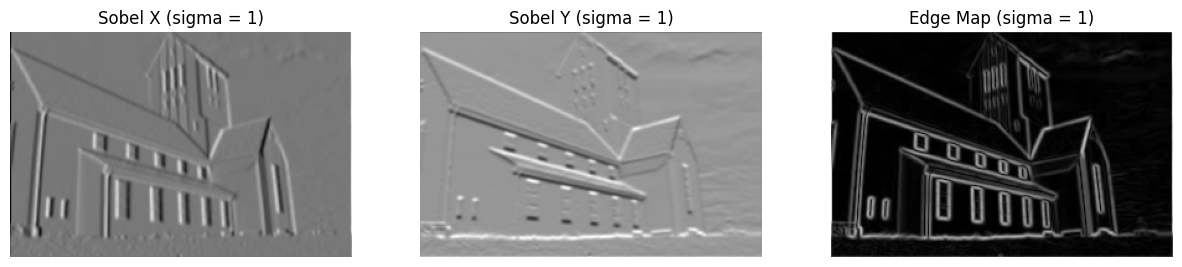

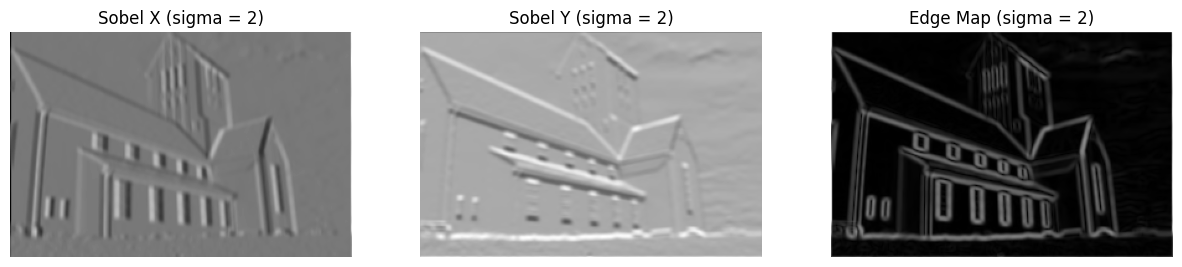

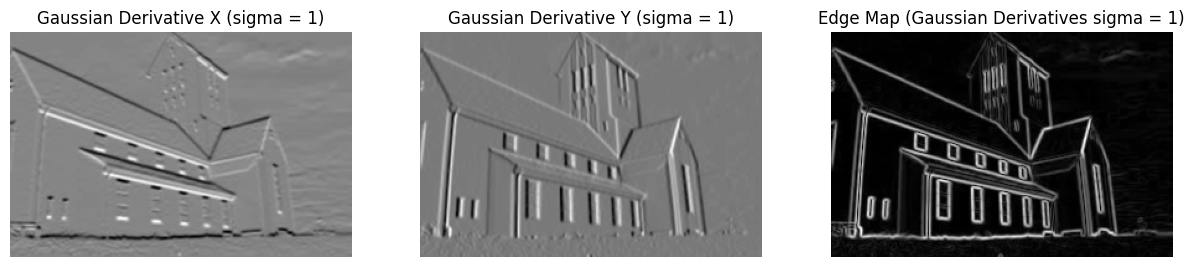

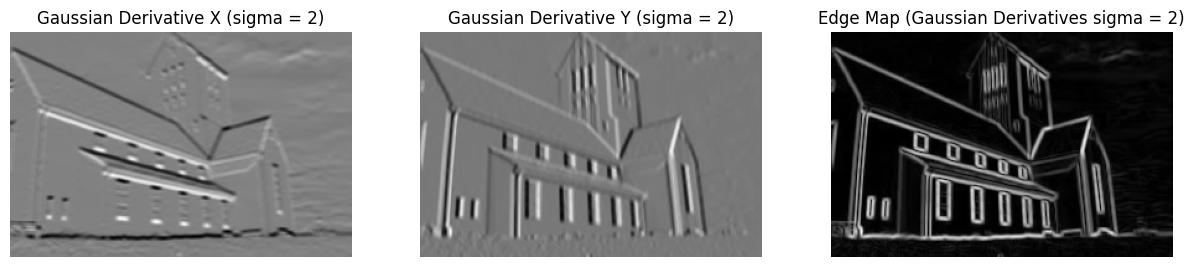

In [38]:
# a)
smoothed_image1 = convolve_gaussian(image, 1)
smoothed_image2 = convolve_gaussian(image, 2)

plot_images([image, smoothed_image1, smoothed_image2], ['Original Image', 'Smoothed Image (sigma = 1)', 'Smoothed Image (sigma = 2)'], 'gray')

# b)
gradient_x1, gradient_y1, edge_map1 = convolve_sobel(smoothed_image1)
gradient_x2, gradient_y2, edge_map2 = convolve_sobel(smoothed_image2)

plot_images([gradient_x1, gradient_y1, edge_map1], ['Sobel X (sigma = 1)', 'Sobel Y (sigma = 1)', 'Edge Map (sigma = 1)'], 'gray')
plot_images([gradient_x2, gradient_y2, edge_map2], ['Sobel X (sigma = 2)', 'Sobel Y (sigma = 2)', 'Edge Map (sigma = 2)'], 'gray')

# c)
gradient_x1, gradient_y1, edge_map1 = convolve_gaussian_derivatives(image, 1)
gradient_x2, gradient_y2, edge_map2 = convolve_gaussian_derivatives(image, 2)

plot_images([gradient_x1, gradient_y1, edge_map1], ['Gaussian Derivative X (sigma = 1)', 'Gaussian Derivative Y (sigma = 1)', 'Edge Map (Gaussian Derivatives sigma = 1)'], 'gray')
plot_images([gradient_x2, gradient_y2, edge_map2], ['Gaussian Derivative X (sigma = 2)', 'Gaussian Derivative Y (sigma = 2)', 'Edge Map (Gaussian Derivatives sigma = 2)'], 'gray')

***Written Answer (b & c):***
While both Sobel filters and Gaussian gradients excel at edge detection, their outputs show subtle differences. Sobel filters produce slightly thicker and less defined edges. This likely stems from the Sobel operator being a simplified version of the Gaussian derivative.

# Question 2 #

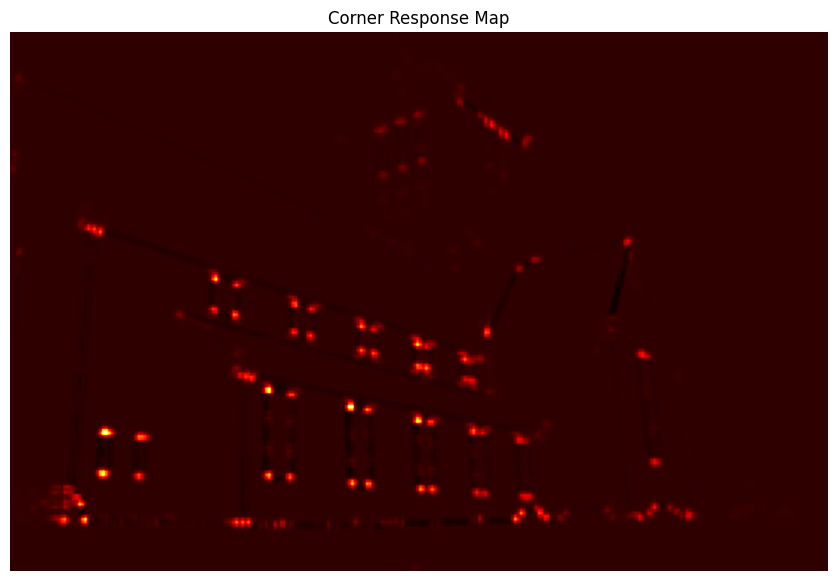

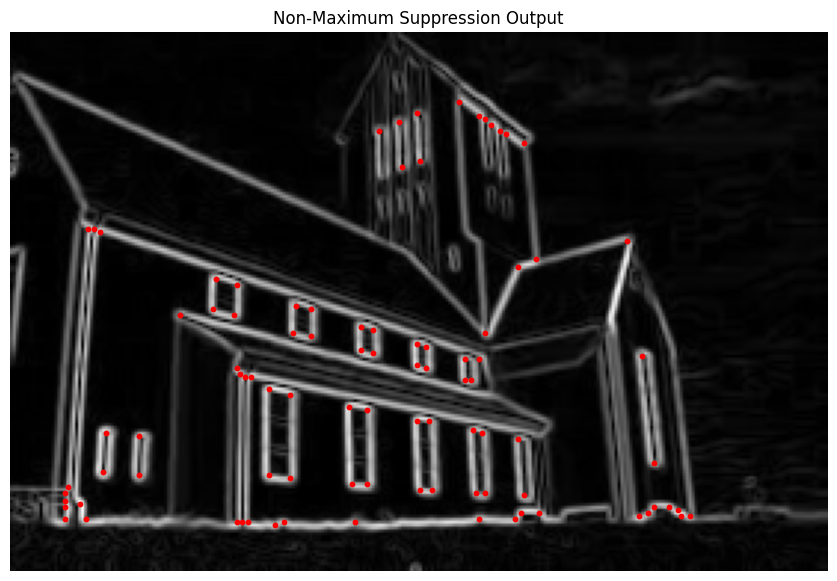

In [39]:
# Find corners
corner_response_map = harris_corner_detection(gradient_x1, gradient_y1)
corners = non_maximum_suppression(corner_response_map, 0.1)

# Extract the indices of the corners
y_coords, x_coords = np.where(corners == 1)

plot_images([corner_response_map], ['Corner Response Map'], 'hot')

# Plot corners with dots
plt.figure(figsize=(15, 7))
plt.imshow(edge_map1, cmap='gray')
plt.scatter(x_coords, y_coords, s=10, color='red')
plt.title('Non-Maximum Suppression Output')
plt.axis('off')
plt.show()